In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import  QuantileTransformer
from sklearn.model_selection import train_test_split

In [2]:
# this function calculates a simple score to evaluate the performance of your neural network
def SimpleScore(model, xtest, ytest):
    pred = model.predict(xtest)

    if (pred.shape != ytest.shape): # important! prevents broadcasting
        pred=pred.reshape(ytest.shape) 

    diff = np.abs(pred - np.clip(ytest,0,1))
    
    return np.mean(np.less(diff,0.5))  

In [3]:
df_all = pd.read_csv('train_higgsBoson.csv')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 31 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   DER_mass_MMC                 250000 non-null  float64
 1   DER_mass_transverse_met_lep  250000 non-null  float64
 2   DER_mass_vis                 250000 non-null  float64
 3   DER_pt_h                     250000 non-null  float64
 4   DER_deltaeta_jet_jet         250000 non-null  float64
 5   DER_mass_jet_jet             250000 non-null  float64
 6   DER_prodeta_jet_jet          250000 non-null  float64
 7   DER_deltar_tau_lep           250000 non-null  float64
 8   DER_pt_tot                   250000 non-null  float64
 9   DER_sum_pt                   250000 non-null  float64
 10  DER_pt_ratio_lep_tau         250000 non-null  float64
 11  DER_met_phi_centrality       250000 non-null  float64
 12  DER_lep_eta_centrality       250000 non-null  float64
 13 

In [4]:
tag_list = list(df_all.columns.values)
tag_list.remove('signal')
goal= 'signal'

X = df_all[tag_list]
Y = df_all[goal]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.75)

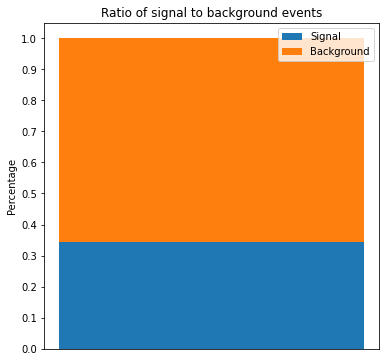

In [5]:
signal_count = df_all[goal].sum()
backgr_count = df_all.shape[0] - signal_count
  # print(signal_count)
  # print(df_all.shape[0] - signal_count)

plt.figure(0, figsize=(6,6))
plt.bar(0, signal_count/df_all.shape[0], bottom= 0, label= "Signal")
plt.bar(0, backgr_count/df_all.shape[0], bottom= signal_count/df_all.shape[0], label= "Background")
plt.ylabel("Percentage")
plt.title("Ratio of signal to background events")
plt.xticks([])
plt.yticks(np.linspace(0, 1, 11))
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

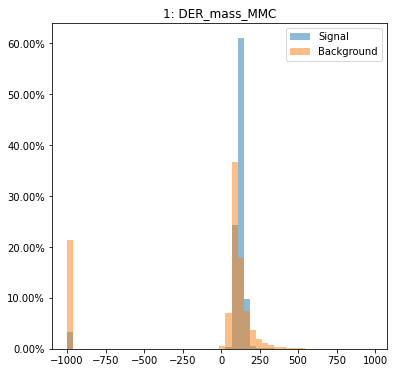

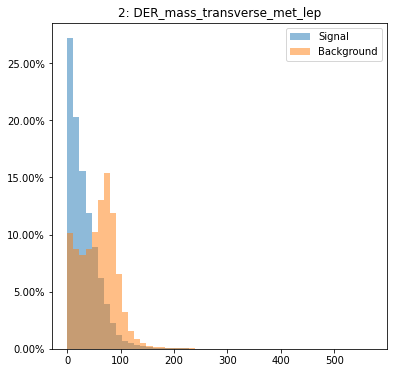

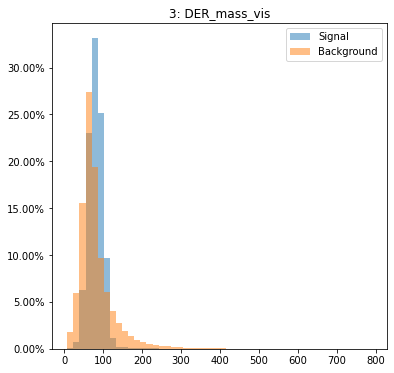

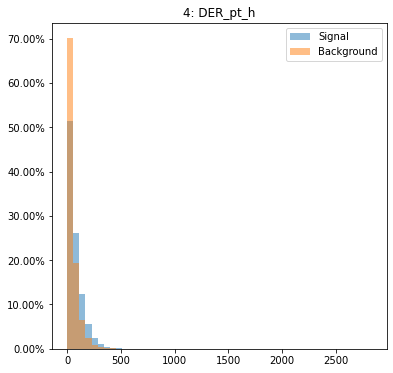

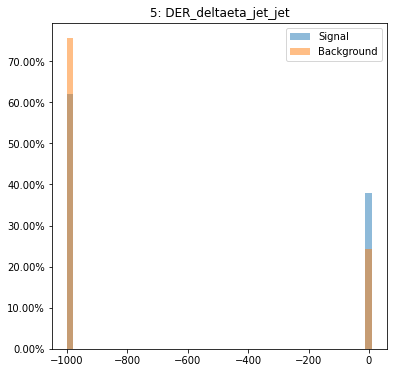

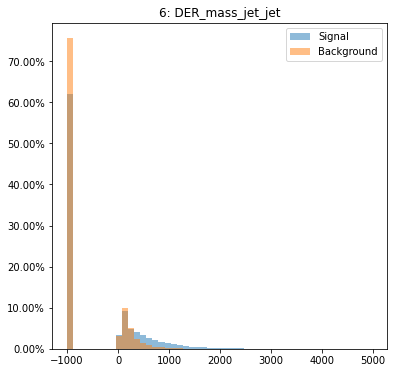

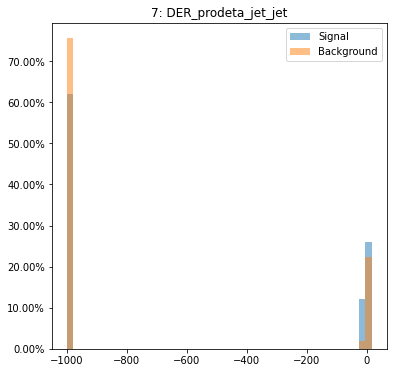

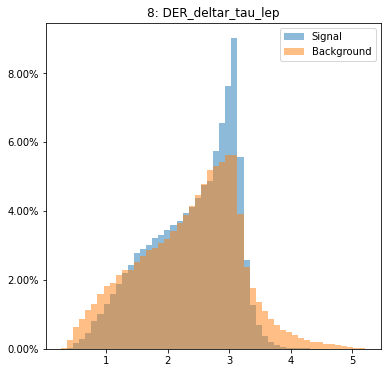

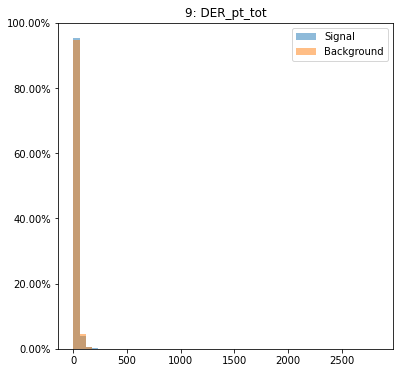

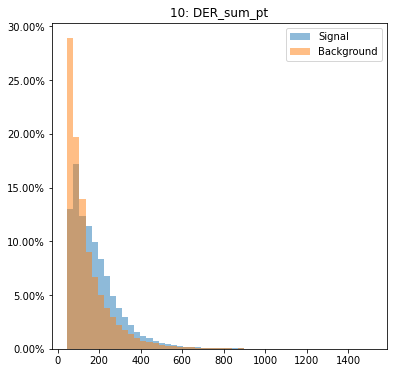

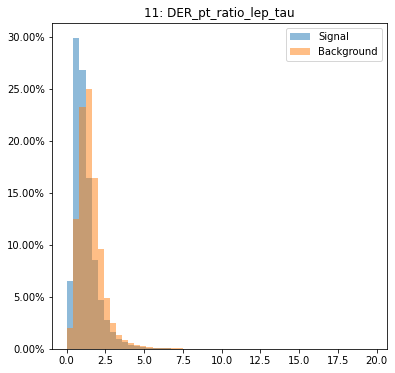

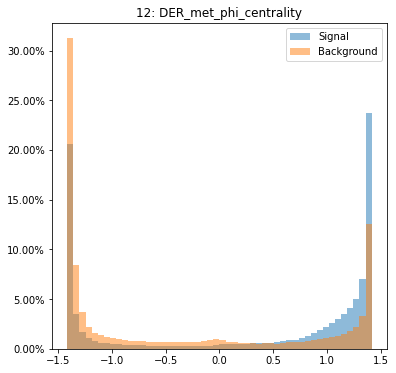

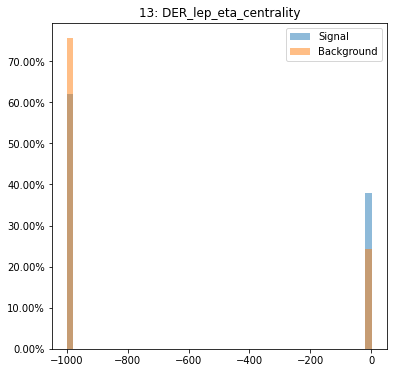

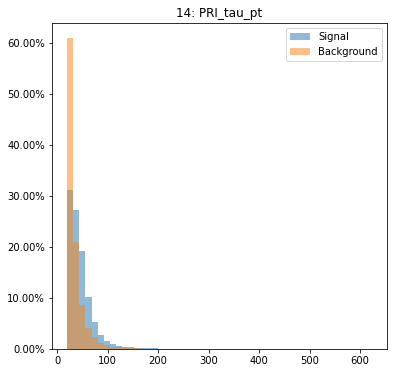

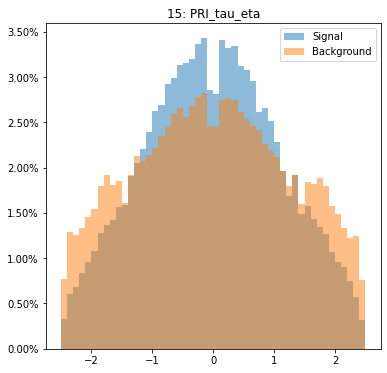

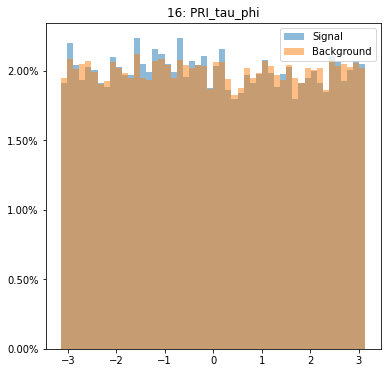

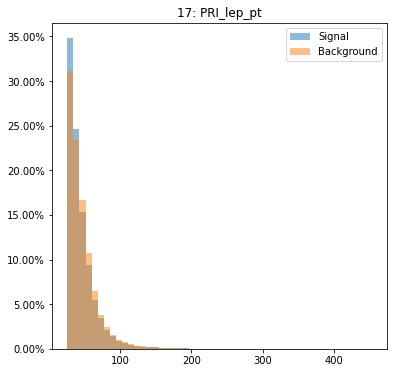

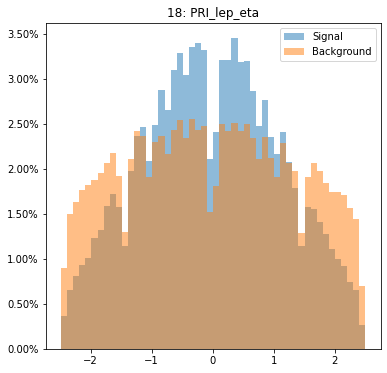

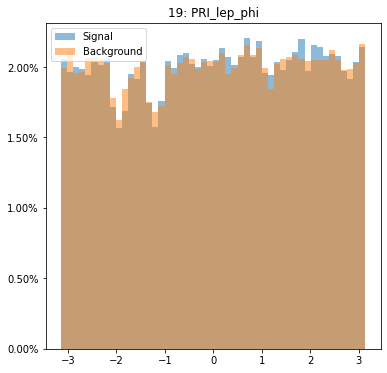

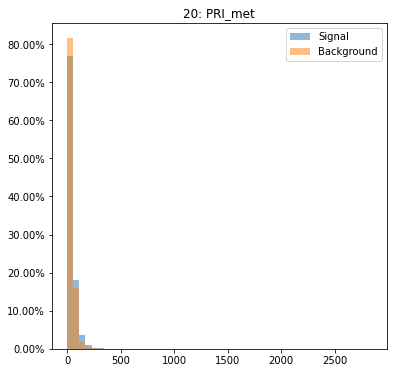

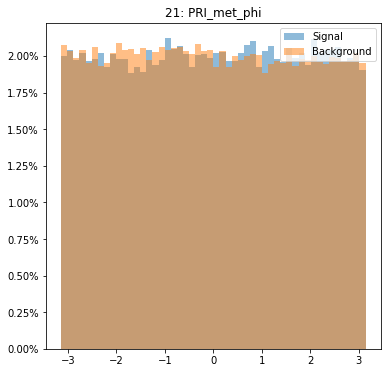

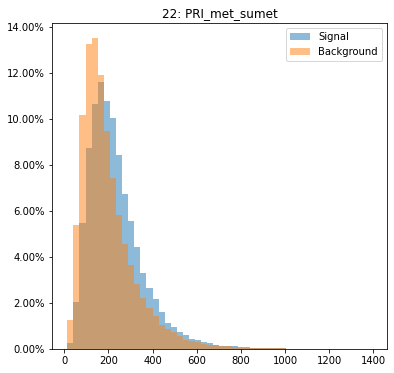

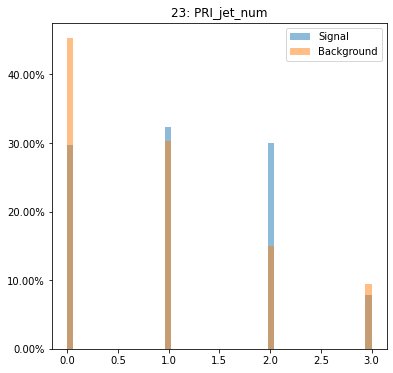

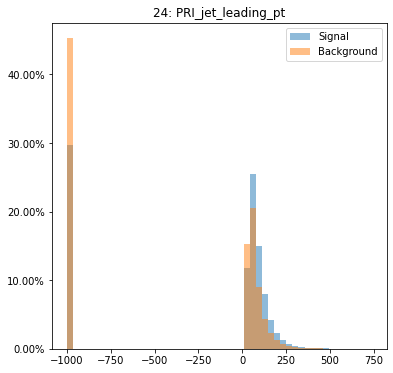

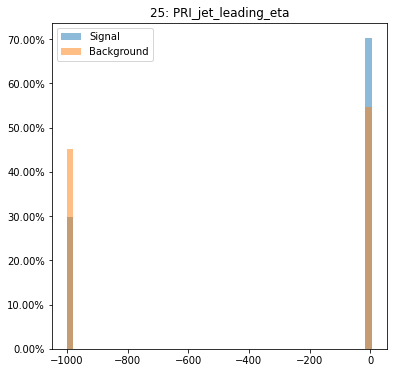

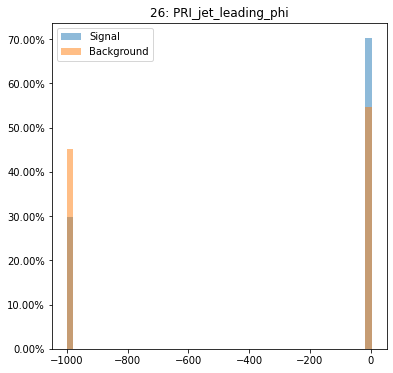

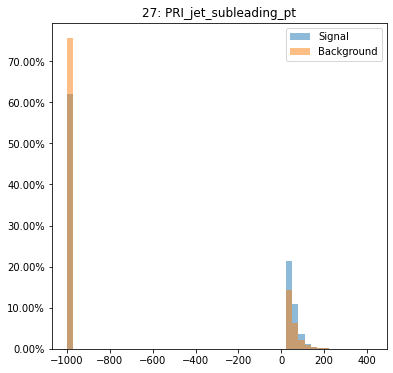

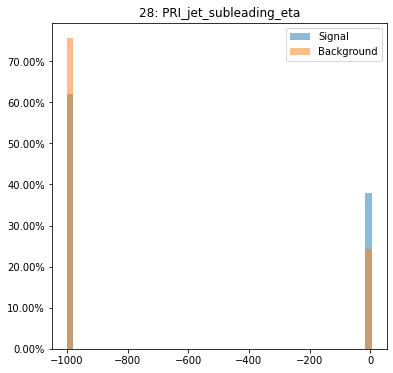

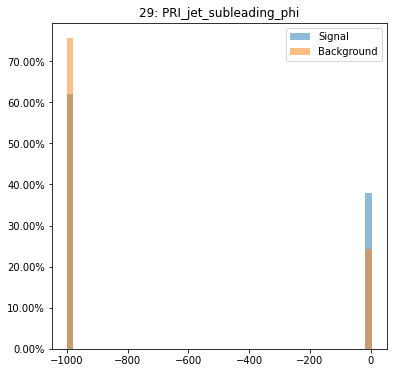

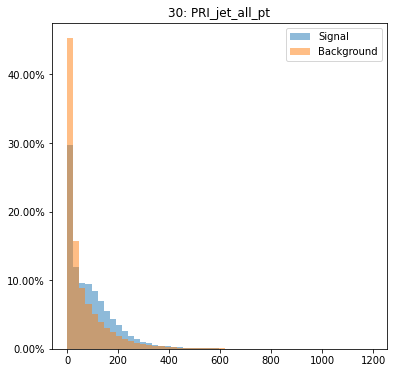

In [6]:
mpl.rcParams['figure.max_open_warning'] = len(tag_list)+2
i = 0
bin_num = 50
for tag in tag_list:
    plt.figure(i)
    fig, ax = plt.subplots(1, 1, figsize=(6,6))

    heights_sig, bins_sig = np.histogram(df_all[tag][df_all[goal]==1], bins = bin_num)
    percent_sig = [i/sum(heights_sig)*100 for i in heights_sig]
    
    heights_bkg, bins_bkg = np.histogram(df_all[tag][df_all[goal]==0], bins = bins_sig)
    percent_bkg = [i/sum(heights_bkg)*100 for i in heights_bkg]
    
    bin_width = (bins_sig[-1]-bins_sig[0])/bin_num
    ax.bar(bins_sig[:-1], percent_sig, width=bin_width, align="edge", alpha= 0.5, label="Signal")
    ax.bar(bins_bkg[:-1], percent_bkg, width=bin_width, align="edge", alpha= 0.5, label="Background")
    
    vals = ax.get_yticks()
    ax.yaxis.set_major_locator(ticker.FixedLocator(vals.tolist()))
    ax.set_yticklabels(['%1.2f%%' %i for i in vals])
    
    plt.title(str(i+1)+": "+tag)
    plt.legend()
    
    i+=1
plt.show()

### Features 9, 16, 17, 19, 20 and 21 are visually so simmilar that they can probably be ommitted
(`DER_pt_tot`, `PRI_tau_phi`, `PRI_lep_pt`, `PRI_lep_phi`, `PRI_met` and `PRI_met_phi`)

In [7]:
tag_list_train = tag_list.copy()

remove_entries = [8, 15, 16, 18, 19, 20]
for i in remove_entries:
    tag_list_train.remove(tag_list[i])

X_gs = df_all[tag_list_train]
Y_gs = df_all[goal]
Xtrain_gs, Xtest_gs, Ytrain_gs, Ytest_gs = train_test_split(X_gs, Y_gs, test_size=0.99)

In [8]:

def buildCustomModel(input_shape, layer_number=[100, 100, 100], act_method=['relu', 'relu', 'relu', 'sigmoid'], batchnormalize= True, optimizer="adam", loss='mean_squared_error'):
    m_list = []
    m_list.append(layers.InputLayer(input_shape=input_shape))
    
    for i in range(len(layer_number)):
        m_list.append(layers.Dense(layer_number[i], activation=act_method[i]))
        if batchnormalize:
            m_list.append(layers.BatchNormalization(axis=1))
    m_list.append(layers.Dense(1, activation= act_method[-1]))

    model = keras.Sequential(m_list)
    model.compile(optimizer=optimizer, loss=loss)
    return model

param_grid = [
    {
    'input_shape': [len(tag_list_train)], 
    'layer_number': [[500, 200], [100, 100], [50, 50]],
    'act_method': [['relu', 'relu', 'sigmoid'], ['linear', 'linear', 'sigmoid']], 
    'batchnormalize':[True],
    'optimizer': ['adam'], 
    'loss': ['poisson', 'binary_crossentropy']
    }, 
    {
    'input_shape': [len(tag_list_train)], 
    'layer_number': [[500, 200, 100], [100, 100, 100], [50, 50, 50]],
    'act_method': [['relu', 'relu', 'relu', 'sigmoid'], ['linear', 'linear', 'linear', 'sigmoid']], 
    'batchnormalize':[True],
    'optimizer': ['adam'], 
    'loss': ['poisson', 'binary_crossentropy']
    }, 
    {
    'input_shape': [len(tag_list_train)], 
    'layer_number': [[500, 200, 100, 50], [100, 100, 100, 100], [50, 50, 50, 50]],
    'act_method': [['relu', 'relu', 'relu', 'relu', 'sigmoid'], ['linear', 'linear', 'linear', 'linear', 'sigmoid']], 
    'batchnormalize':[True],
    'optimizer': ['adam'], 
    'loss': ['poisson', 'binary_crossentropy']
    }
    ]


model = KerasClassifier(build_fn=buildCustomModel, verbose=0)
gs = GridSearchCV(estimator=model,param_grid=param_grid, cv=2, n_jobs=None, scoring='accuracy', verbose=2)
fitted_model = gs.fit(Xtrain_gs, Ytrain_gs, epochs= 50)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200], loss=poisson, optimizer=adam; total time=  14.0s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200], loss=poisson, optimizer=adam; total time=   8.0s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200], loss=binary_crossentropy, optimizer=adam; total time=   8.9s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200], loss=binary_crossentropy, optimizer=adam; total time=   8.5s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100], loss=poisson, optimizer=adam; total time=   7.9s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100], loss=poisson, optimizer=adam; total time=   7.9s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100], loss=binary_crossentropy, optimizer=adam; total time=   8.3s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100], loss=binary_crossentropy, optimizer=adam; total time=   8.9s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50], loss=poisson, optimizer=adam; total time=   9.2s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50], loss=poisson, optimizer=adam; total time=   8.3s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50], loss=binary_crossentropy, optimizer=adam; total time=   8.7s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50], loss=binary_crossentropy, optimizer=adam; total time=   8.8s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200], loss=poisson, optimizer=adam; total time=   8.1s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200], loss=poisson, optimizer=adam; total time=   8.3s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200], loss=binary_crossentropy, optimizer=adam; total time=   8.5s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200], loss=binary_crossentropy, optimizer=adam; total time=   8.7s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100], loss=poisson, optimizer=adam; total time=   8.3s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100], loss=poisson, optimizer=adam; total time=   8.2s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100], loss=binary_crossentropy, optimizer=adam; total time=   8.7s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100], loss=binary_crossentropy, optimizer=adam; total time=   8.5s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50], loss=poisson, optimizer=adam; total time=   8.3s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50], loss=poisson, optimizer=adam; total time=   8.4s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50], loss=binary_crossentropy, optimizer=adam; total time=   8.6s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50], loss=binary_crossentropy, optimizer=adam; total time=   8.7s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100], loss=poisson, optimizer=adam; total time=  10.6s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100], loss=poisson, optimizer=adam; total time=  10.7s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100], loss=binary_crossentropy, optimizer=adam; total time=  11.0s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100], loss=binary_crossentropy, optimizer=adam; total time=  11.2s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100], loss=poisson, optimizer=adam; total time=  10.4s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100], loss=poisson, optimizer=adam; total time=  10.9s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100], loss=binary_crossentropy, optimizer=adam; total time=  11.1s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100], loss=binary_crossentropy, optimizer=adam; total time=  10.9s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50], loss=poisson, optimizer=adam; total time=  12.0s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50], loss=poisson, optimizer=adam; total time=  10.6s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50], loss=binary_crossentropy, optimizer=adam; total time=  11.4s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50], loss=binary_crossentropy, optimizer=adam; total time=  11.2s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100], loss=poisson, optimizer=adam; total time=  10.4s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100], loss=poisson, optimizer=adam; total time=  10.3s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100], loss=binary_crossentropy, optimizer=adam; total time=  11.1s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100], loss=binary_crossentropy, optimizer=adam; total time=  11.0s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100], loss=poisson, optimizer=adam; total time=  10.4s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100], loss=poisson, optimizer=adam; total time=  10.4s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100], loss=binary_crossentropy, optimizer=adam; total time=  11.0s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100], loss=binary_crossentropy, optimizer=adam; total time=  11.2s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50], loss=poisson, optimizer=adam; total time=  10.5s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50], loss=poisson, optimizer=adam; total time=  10.2s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50], loss=binary_crossentropy, optimizer=adam; total time=  10.7s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50], loss=binary_crossentropy, optimizer=adam; total time=  10.8s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100, 50], loss=poisson, optimizer=adam; total time=  12.9s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100, 50], loss=poisson, optimizer=adam; total time=  13.0s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100, 50], loss=binary_crossentropy, optimizer=adam; total time=  13.5s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100, 50], loss=binary_crossentropy, optimizer=adam; total time=  13.5s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100, 100], loss=poisson, optimizer=adam; total time=  12.9s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100, 100], loss=poisson, optimizer=adam; total time=  12.8s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100, 100], loss=binary_crossentropy, optimizer=adam; total time=  13.3s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100, 100], loss=binary_crossentropy, optimizer=adam; total time=  13.1s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50, 50], loss=poisson, optimizer=adam; total time=  13.0s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50, 50], loss=poisson, optimizer=adam; total time=  12.6s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50, 50], loss=binary_crossentropy, optimizer=adam; total time=  13.1s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['relu', 'relu', 'relu', 'relu', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50, 50], loss=binary_crossentropy, optimizer=adam; total time=  13.2s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100, 50], loss=poisson, optimizer=adam; total time=  12.6s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100, 50], loss=poisson, optimizer=adam; total time=  12.7s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100, 50], loss=binary_crossentropy, optimizer=adam; total time=  13.1s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[500, 200, 100, 50], loss=binary_crossentropy, optimizer=adam; total time=  13.3s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100, 100], loss=poisson, optimizer=adam; total time=  12.7s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100, 100], loss=poisson, optimizer=adam; total time=  12.8s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100, 100], loss=binary_crossentropy, optimizer=adam; total time=  13.1s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[100, 100, 100, 100], loss=binary_crossentropy, optimizer=adam; total time=  13.1s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50, 50], loss=poisson, optimizer=adam; total time=  12.7s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50, 50], loss=poisson, optimizer=adam; total time=  12.6s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50, 50], loss=binary_crossentropy, optimizer=adam; total time=  13.3s


D:\Programme\Python3_8_MiniConda\envs\TF2_5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END act_method=['linear', 'linear', 'linear', 'linear', 'sigmoid'], batchnormalize=True, input_shape=24, layer_number=[50, 50, 50, 50], loss=binary_crossentropy, optimizer=adam; total time=  13.1s


In [9]:
fitted_model.best_params_

{'act_method': ['relu', 'relu', 'sigmoid'],
 'batchnormalize': True,
 'input_shape': 24,
 'layer_number': [100, 100],
 'loss': 'binary_crossentropy',
 'optimizer': 'adam'}

In [10]:
real_model = keras.Sequential([
    layers.InputLayer(input_shape=len(tag_list_train)),
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(axis=1),
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(axis=1),
    layers.Dense(1, activation='sigmoid'),
])
real_model.compile(optimizer='adam', loss='binary_crossentropy')
real_model.fit(Xtrain[tag_list_train], Ytrain, epochs= 250)

Epoch 1/250
1954/1954 [==============================] - 9s 5ms/step - loss: 0.4890
Epoch 2/250
1954/1954 [==============================] - 9s 5ms/step - loss: 0.4509
Epoch 3/250
1954/1954 [==============================] - 9s 4ms/step - loss: 0.4409
Epoch 4/250
1954/1954 [==============================] - 9s 4ms/step - loss: 0.4363
Epoch 5/250
1954/1954 [==============================] - 9s 4ms/step - loss: 0.4321
Epoch 6/250
1954/1954 [==============================] - 9s 4ms/step - loss: 0.4288
Epoch 7/250
1954/1954 [==============================] - 9s 5ms/step - loss: 0.4257
Epoch 8/250
1954/1954 [==============================] - 9s 4ms/step - loss: 0.4239
Epoch 9/250
1954/1954 [==============================] - 9s 5ms/step - loss: 0.4210
Epoch 10/250
1954/1954 [==============================] - 10s 5ms/step - loss: 0.4181
Epoch 11/250
1954/1954 [==============================] - 9s 4ms/step - loss: 0.4185
Epoch 12/250
1954/1954 [==============================] - 9s 5ms/step - l

In [11]:
print("Model score: ", SimpleScore(real_model, Xtest[tag_list_train], Ytest))

Model score:  0.8298773333333334
